In [1]:
%matplotlib inline

import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy import stats
import warnings

from preprocess_utils import arctic_mean, Arctic_SIextent

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


#### Load dataset

In [2]:
# Load dataset
collection_fname = 'dset_dict_temp_historical.npy'
#collection_fname = 'dset_dict_temp_piControl.npy'

dset_dict = np.load(collection_fname, allow_pickle='TRUE').item()
first_dset = list(dset_dict.keys())[0]
models_intersect = dset_dict[first_dset].keys()

# taking the temp out of collection_fname
collection_fname = collection_fname[0:10] + collection_fname[15:]

#### Calculate bulk totals (Arctic sea ice extent and mean Arctic temperature): 

In [3]:
si_dict = dset_dict['siconc']
tas_dict = dset_dict['tas']

In [4]:
for m in models_intersect:
    si_dict[m]['sie_tot_arc'] = Arctic_SIextent(si_dict[m]['siconc'], si_dict[m]['areacello'])
    tas_dict[m]['tas_arc_mean'] = arctic_mean(tas_dict[m], tas_dict[m]['tas'], 70)

In [5]:
dset_dict['siconc'] = si_dict
dset_dict['tas'] = tas_dict

#### Calculate climatologies, anomalies, stds of basic variables

In [6]:
# Calculate climatology, anomalies and stds for variables matching dataset keys

# There are some performance warnings from dask. Hopefully not an issue?
warnings.filterwarnings('ignore')

for d in dset_dict.keys():
    if d not in ['areacello', 'areacella']:
        for m in models_intersect:

            dset_dict[d][m][d + '_clim'] = dset_dict[d][m][d].groupby('time.month').mean(dim='time')
            dset_dict[d][m][d + '_anom'] = dset_dict[d][m][d].groupby('time.month') - dset_dict[d][m][d + '_clim']
            dset_dict[d][m][d + '_std'] = dset_dict[d][m][d].groupby('time.month').std()
            
warnings.filterwarnings('default')

In [7]:
# Possibly want to detrend the data. Repurpose this code if so:
#from scipy.signal import detrend
#sst_anom_detrended = xr.apply_ufunc(detrend, sst_anom.fillna(0),
#                                    kwargs={'axis': 0}).where(~sst_anom.isnull())

# Actually more likely to want to filter or remove moving average probably.

#### Calculate climatologies, anomalies, stds of bulk variables

In [8]:
# Calculate climatology, anomalies and stds for Arctic sea ice extent and mean Arctic temperature

# There are some performance warnings from dask. Hopefully not an issue?
warnings.filterwarnings('ignore')

# n.b. total anomalies don't add up to exactly zero for sie_tot_arc_anom
# this is just a precision thing because xarrays are only 8 sig figs

for m in models_intersect:
    dset_dict['siconc'][m]['sie_tot_arc_clim'] = dset_dict['siconc'][m]['sie_tot_arc'].groupby('time.month').mean(dim='time')
    dset_dict['siconc'][m]['sie_tot_arc_anom'] = dset_dict['siconc'][m]['sie_tot_arc'].groupby('time.month') - dset_dict['siconc'][m]['sie_tot_arc_clim']
    
    dset_dict['tas'][m]['tas_arc_mean_clim'] = dset_dict['tas'][m]['tas_arc_mean'].groupby('time.month').mean(dim='time')
    dset_dict['tas'][m]['tas_arc_mean_anom'] = dset_dict['tas'][m]['tas_arc_mean'].groupby('time.month') -  dset_dict['tas'][m]['tas_arc_mean_clim']        

warnings.filterwarnings('default')

#### Save

In [9]:
# Save dictionaries for future use
save_flag = True
if save_flag:
    if dset_dict:
        np.save(collection_fname, dset_dict)

#### Plots

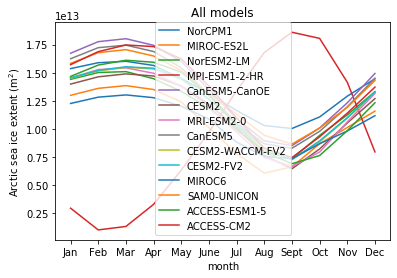

In [10]:
# Plot Arctic sea ice extent climatology
month_lab = ['Jan','Feb','Mar','Apr','May','June','Jul','Aug','Sept','Oct','Nov','Dec']

warnings.filterwarnings('ignore')

for m in models_intersect:
    dset_dict['siconc'][m]['sie_tot_arc_clim'].isel(member_id=0).plot(label='sie mean')
    plt.xticks(np.arange(1,13,1), month_lab)
    plt.ylabel('Arctic sea ice extent (m$^{2}$)')
    plt.title('All models')
    plt.legend(models_intersect)
    
warnings.filterwarnings('default')

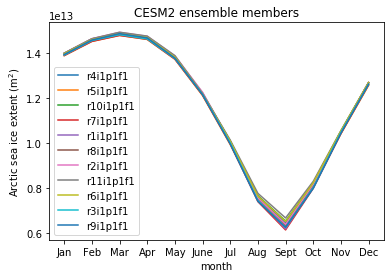

In [11]:
# Plot Arctic sea ice extent climatology
month_lab = ['Jan','Feb','Mar','Apr','May','June','Jul','Aug','Sept','Oct','Nov','Dec']

warnings.filterwarnings('ignore')

for em in dset_dict['siconc']['CESM2']['member_id'].values:
    dset_dict['siconc']['CESM2']['sie_tot_arc_clim'].sel(member_id=em).plot(label='sie mean')
    plt.xticks(np.arange(1,13,1), month_lab)
    plt.ylabel('Arctic sea ice extent (m$^{2}$)')
    plt.title('CESM2 ensemble members')
    plt.legend(dset_dict['siconc']['CESM2']['member_id'].values)
    
warnings.filterwarnings('default')

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


Text(0, 0.5, 'Arctic sea ice extent anom (m$^{2}$)')

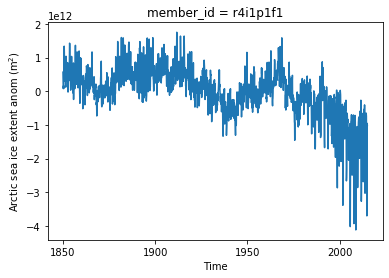

In [12]:
# Example of sea ice extent anomaly timeseries
dset_dict['siconc']['CESM2']['sie_tot_arc_anom'].isel(member_id=0).plot()
plt.xlabel('Time')
plt.ylabel('Arctic sea ice extent anom (m$^{2}$)')

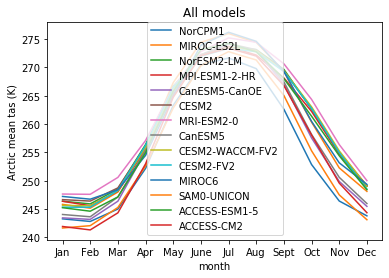

In [13]:
# Plot Arctic temperature climatology
month_lab = ['Jan','Feb','Mar','Apr','May','June','Jul','Aug','Sept','Oct','Nov','Dec']

warnings.filterwarnings('ignore')

for m in models_intersect:
    dset_dict['tas'][m]['tas_arc_mean_clim'].isel(member_id=0).plot(label='tas mean')
    plt.xticks(np.arange(1,13,1), month_lab)
    plt.ylabel('Arctic mean tas (K)')
    plt.title('All models')
    plt.legend(models_intersect)
    
warnings.filterwarnings('default')

Text(0, 0.5, 'Arctic mean tas (K)')

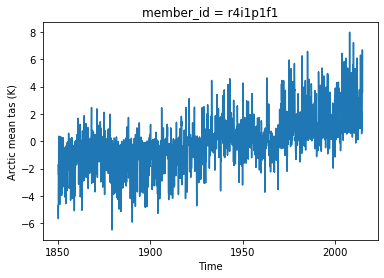

In [14]:
# Example of arctic temperature anomaly timeseries
dset_dict['tas']['CESM2']['tas_arc_mean_anom'].isel(member_id=0).plot()
plt.xlabel('Time')
plt.ylabel('Arctic mean tas (K)')

In [85]:
# Problems:
#1. Go home access you're drunk